In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit

sns.set_theme(style="whitegrid")
ucs = pd.read_csv('../../data/clean/ucs_cleaned.csv', parse_dates=['launch_date'])

LAUNCH MASS

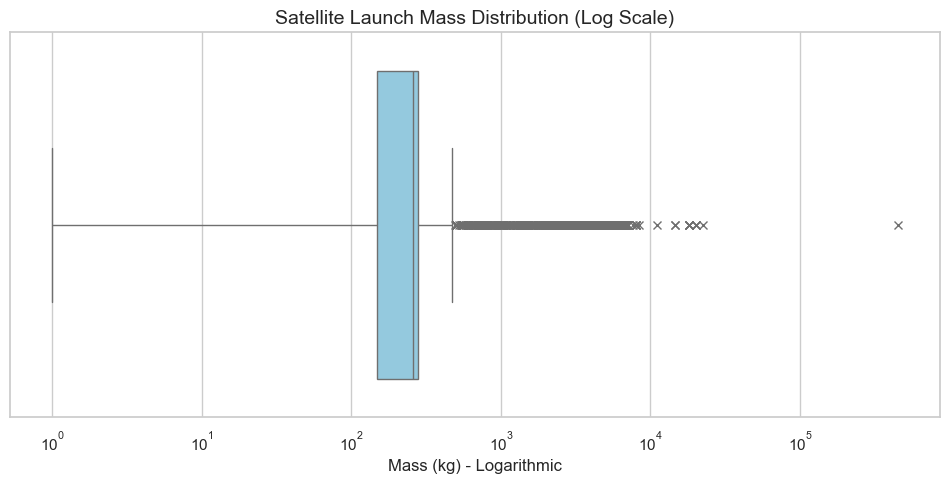

In [2]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=ucs['launch_mass_kg'], color='skyblue', 
            flierprops={"marker": "x", "markerfacecolor": "red"})

plt.xscale('log')

plt.title('Satellite Launch Mass Distribution (Log Scale)', fontsize=14)
plt.xlabel('Mass (kg) - Logarithmic', fontsize=12)
plt.show()

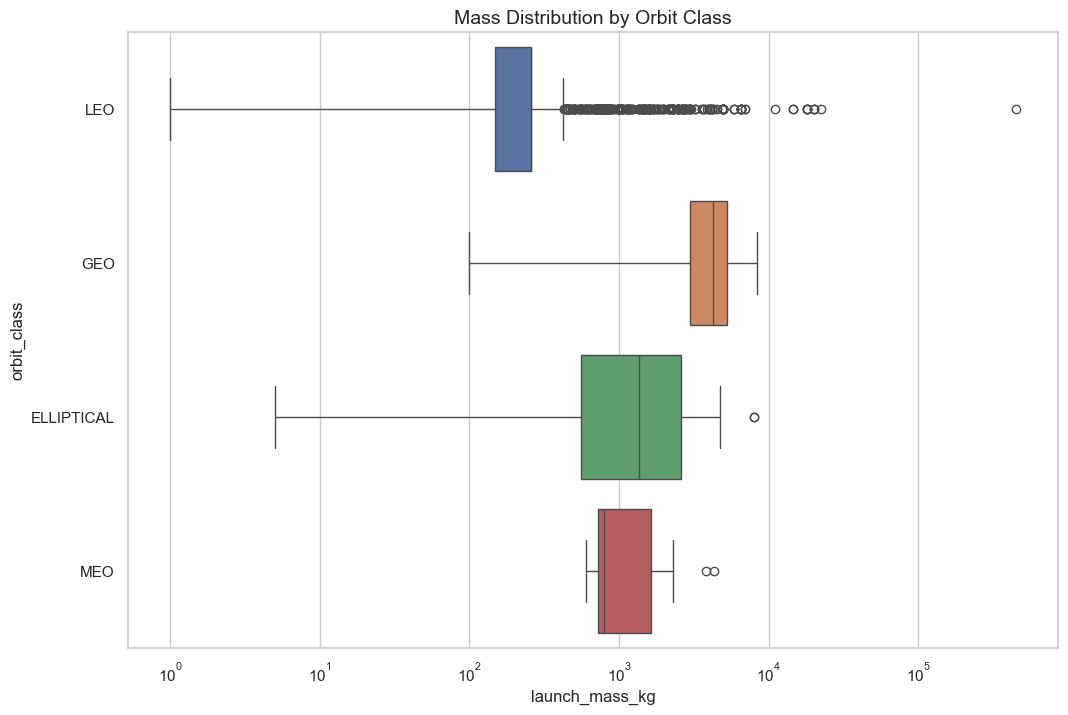

In [3]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=ucs, 
            x='launch_mass_kg', 
            y='orbit_class', 
            hue='orbit_class', 
            legend=False)

plt.xscale('log')

plt.title('Mass Distribution by Orbit Class', fontsize=14)
plt.show()

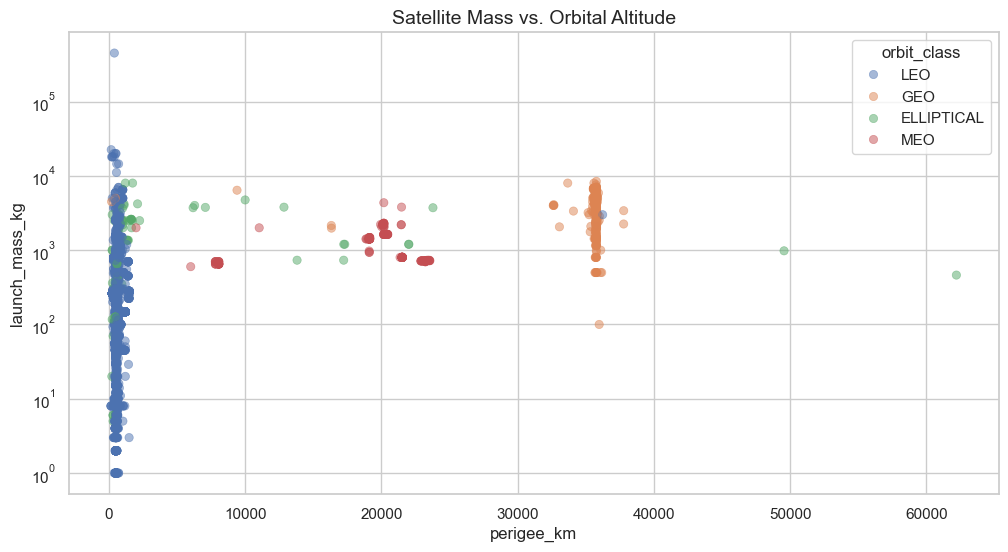

In [4]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
                data = ucs,
                x = 'perigee_km',
                y = 'launch_mass_kg', 
                hue = 'orbit_class',
                alpha = 0.5,
                edgecolor = None)

plt.yscale('log')
plt.title('Satellite Mass vs. Orbital Altitude', fontsize=14)
plt.show()

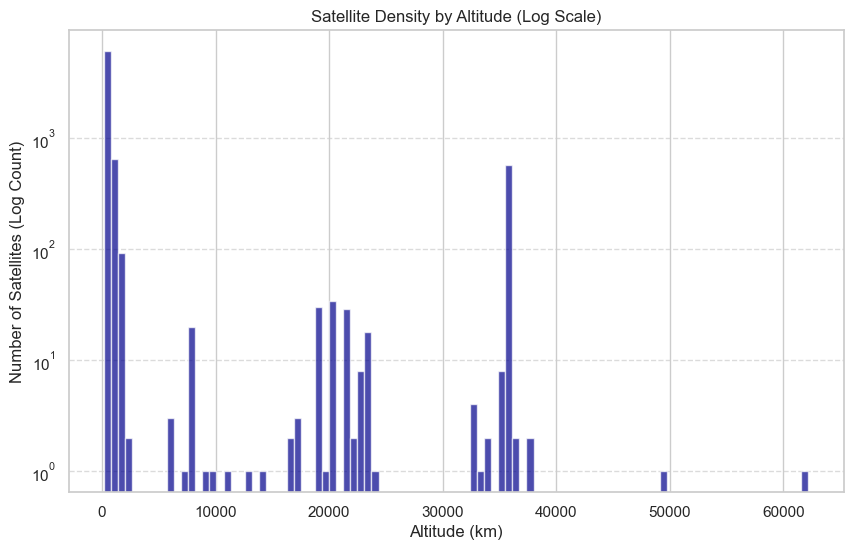

In [5]:
plt.figure(figsize=(10,6))
plt.hist(ucs['perigee_km'], bins=100, color='darkblue', alpha=0.7)
plt.yscale('log') 
plt.title('Satellite Density by Altitude (Log Scale)')
plt.xlabel('Altitude (km)')
plt.ylabel('Number of Satellites (Log Count)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Axes: xlabel='launch_date'>

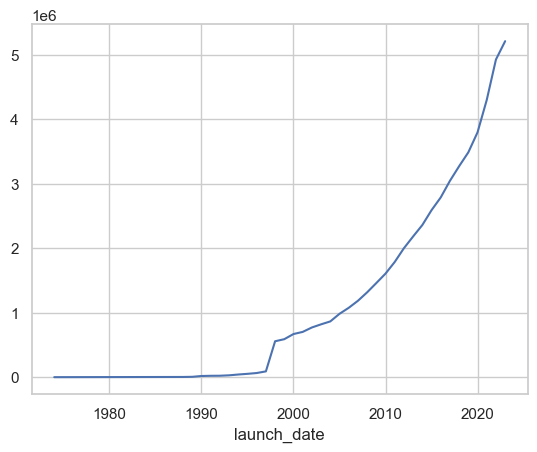

In [6]:
mass_trend = ucs.groupby(ucs['launch_date'].dt.year)['launch_mass_kg'].sum().cumsum()
mass_trend.plot()

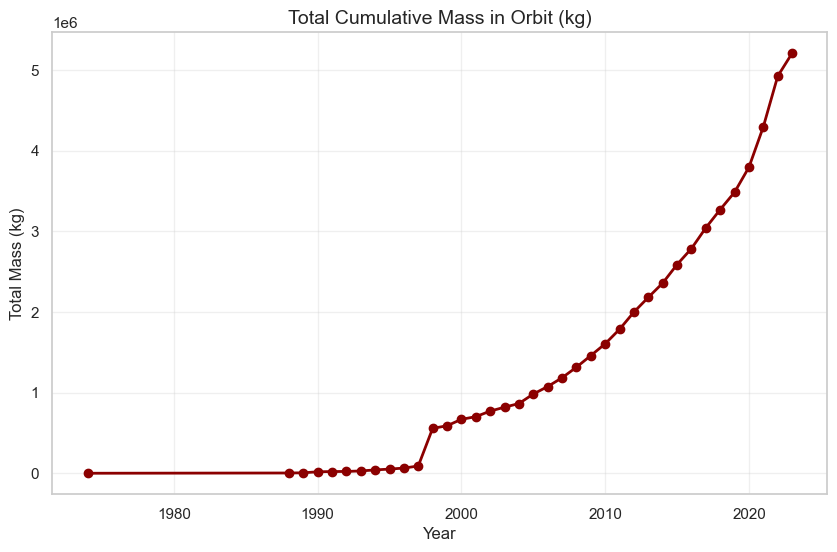

In [7]:
mass_by_year = ucs.groupby(ucs['launch_date'].dt.year)['launch_mass_kg'].sum().cumsum()

plt.figure(figsize=(10, 6))

mass_by_year.plot(kind='line', marker='o', color='darkred', linewidth=2)

plt.title('Total Cumulative Mass in Orbit (kg)', fontsize=14)
plt.ylabel('Total Mass (kg)')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.show()

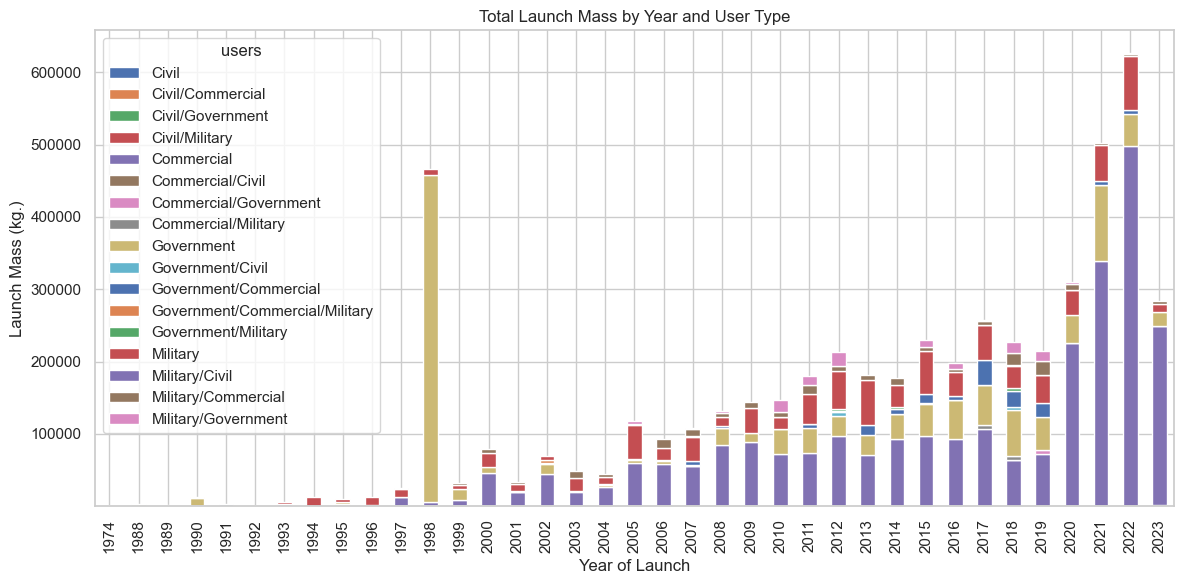

In [8]:
ucs['launch_date'] = pd.to_datetime(ucs['launch_date'])

ucs['Year'] = ucs['launch_date'].dt.year

summary = ucs.pivot_table(
    index='Year',
    columns='users',
    values='launch_mass_kg',
    aggfunc='sum',
    observed=False
)

summary.plot(kind='bar', figsize=(12, 6), rot=90, stacked=True)

plt.title("Total Launch Mass by Year and User Type")
plt.ylabel("Launch Mass (kg.)")
plt.xlabel("Year of Launch")
plt.tight_layout()
plt.show()

This is where I will start to organize my thoughts properly, start asking questions, and begin telling this datasets stories. I am leaving everything I have already added, for reference, until I reorganize everything as I want it.

# Democratization of Space

Democratization of space is the story of how space travel shifted from being exclusively superpowers (USA, Russia, China) to an open market of private companies, universities, and developing countries.

# Old Space

The following visualization shows that space was dominated by just a handful of superpowers pre-2012.

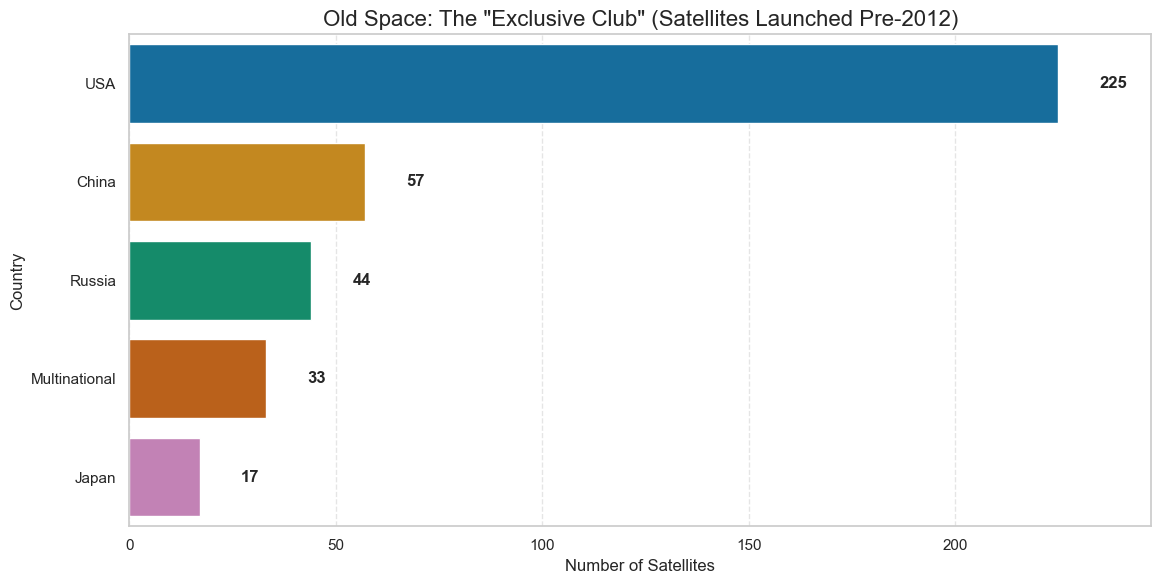

In [9]:
# Old Space
old_space = ucs[ucs['Year'] < 2012]

country_counts_old = old_space['country_operator'].value_counts().head(5)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts_old.values, y=country_counts_old.index, hue=country_counts_old.index, palette='colorblind')

plt.title('Old Space: The "Exclusive Club" (Satellites Launched Pre-2012)', fontsize=16)

plt.xlabel('Number of Satellites')
plt.ylabel('Country')

plt.grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(country_counts_old.values):
    plt.text(v + 10, i, str(v), va='center', fontweight='bold')

plt.tight_layout()

# Get the current maximum x-value and add 10% padding
plt.xlim(right=country_counts_old.max() * 1.1)

plt.show()

The following 2 visualtions show that space used to be reserved for big governments and military applications. It may appear that commercial has a larger slice, but 40% commercial is still less than 60% Military/Government/Civil. Mathmatically, non-commercial users still held the majority.

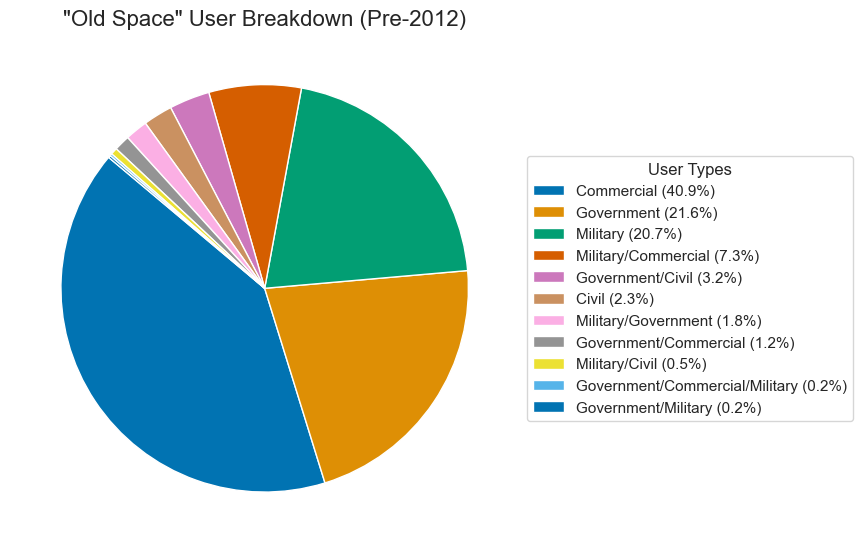

In [10]:
# get all users before 2012 and then count the number of times that user appears in the dataset before 2012
old_space = ucs[ucs['Year'] < 2012]
user_counts_old = old_space['users'].value_counts()

total = user_counts_old.sum()
percentages = [(x / total * 100) for x in user_counts_old]
legend_labels = [f'{l} ({s:1.1f}%)' for l, s in zip(user_counts_old.index, percentages)]

fig, ax = plt.subplots(figsize=(8, 6))

wedges, texts = ax.pie(
    user_counts_old,
    wedgeprops={'width': 1},
    startangle=140,
    colors=sns.color_palette('colorblind')
)

ax.legend(wedges, legend_labels,
          title="User Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1)) # anchor legend to the right of the box so it doesnt obstruct the pie view

plt.title('"Old Space" User Breakdown (Pre-2012)', fontsize=16)
plt.tight_layout()
plt.show()

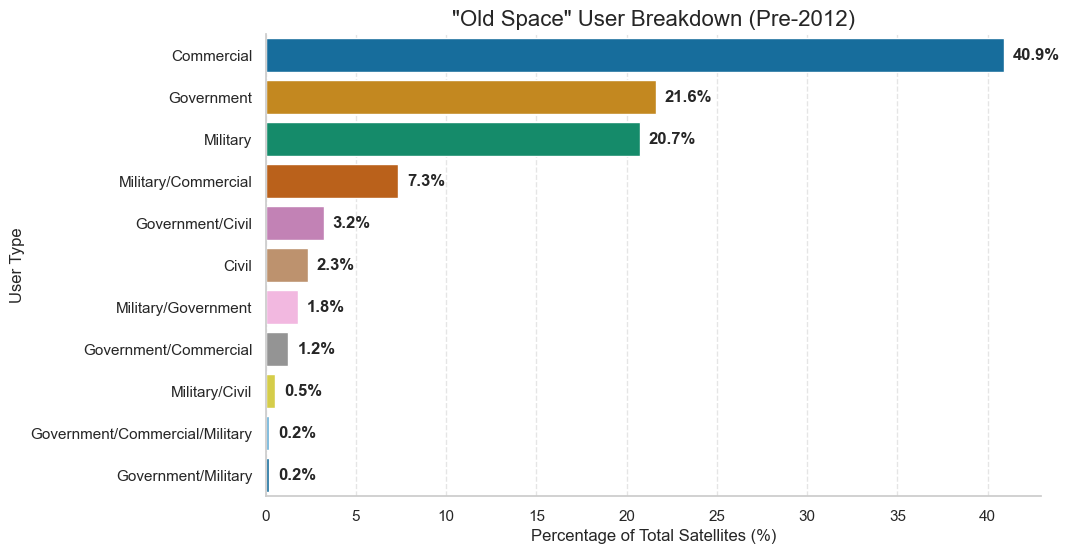

In [11]:
old_space = ucs[ucs['Year'] < 2012]
user_counts_old = old_space['users'].value_counts()

user_pcts_old = (user_counts_old / user_counts_old.sum()) * 100

plt.figure(figsize=(10, 6))

sns.barplot(x=user_pcts_old.values, y=user_pcts_old.index, hue=user_pcts_old.index, palette='colorblind')

plt.title('"Old Space" User Breakdown (Pre-2012)', fontsize=16)
plt.xlabel('Percentage of Total Satellites (%)')
plt.ylabel('User Type')
plt.grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(user_pcts_old.values):
    plt.text(v + .5, i, f'{v:.1f}%', va='center', fontweight='bold')
sns.despine()
plt.show()

The next visualization shows the explosion of the commercial sector in space.

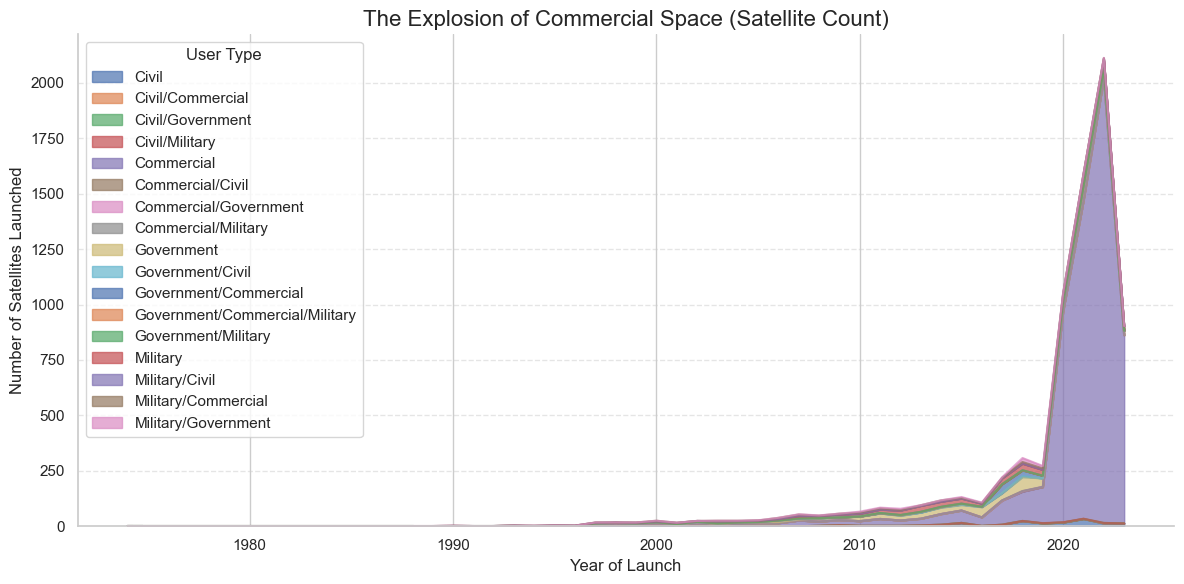

In [12]:
sat_counts = ucs.pivot_table(
    index='Year', 
    columns='users', 
    values='satellite_name', 
    aggfunc='count'
).fillna(0)

ax = sat_counts.plot(kind='area', stacked=True, figsize=(12, 6), alpha=0.7)

plt.title('The Explosion of Commercial Space (Satellite Count)', fontsize=16)
plt.ylabel('Number of Satellites Launched')
plt.xlabel('Year of Launch')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='User Type')
sns.despine()
plt.tight_layout()
plt.show()

The next visualization shows where we are headed with this, the 'Crowded Skies' view so to speak.  This chart shows how orbital debris collection isnt happening evenly, its not spread out across all of earths orbits etc. This will show that while GEO orbit is stable, the increase in debris within LEO orbit is exponential so this is where the debris clutter risk is the highest. The following visualization is appropriate because it clearly shows the number of objects launched, for each year, within each orbit class.  This shows the debris distribution to be climbing exponentially within the LEO orbit class specficially. I ensured accurracy by comparing exponential growth vs linear growth. I will almost always try to use pallettes such as 'colorblind', where possible, for neutral accessability color options.  I also like to make visualizations a bit on the larger side to improve visibility.

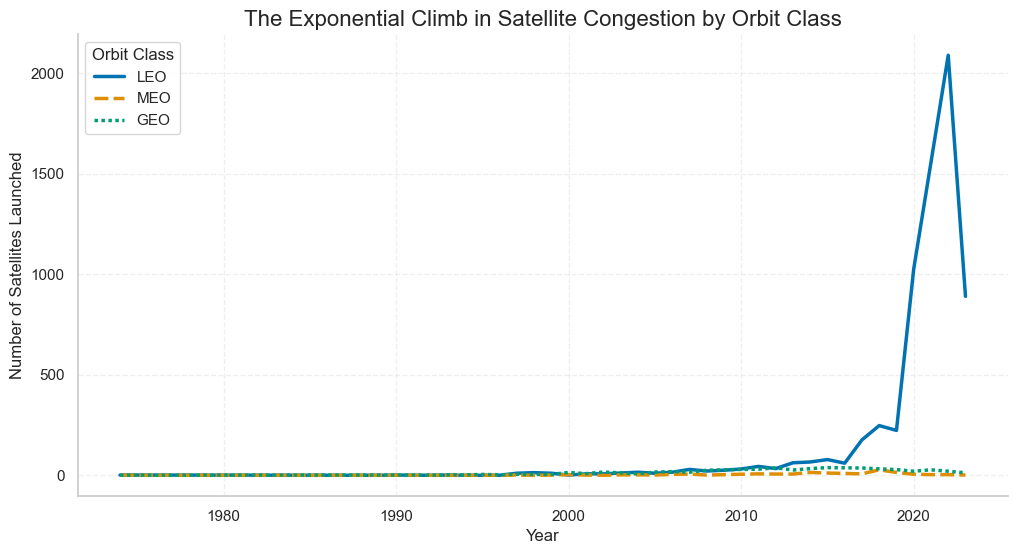

In [13]:
orbit_evolution = ucs.pivot_table(
    index='Year', # rows
    columns='orbit_class', # columns 
    values='satellite_name', # data to count, almost anything could have done, but satellite_name works for counting unique objects
    aggfunc='count' # count the number of times a satellite name appears for this year and orbit class.
).fillna(0)

# Focus on the main 3 classes to avoid clutter, elliptical isnt really needed its just noise.
# Elliptical orbit sates are not really a risk, there are literally a couple dozen within the elliptical orbit.
# Leo orbit is where all the clutter is starting to pile up.  All of the commercial flights, launch debris, sate
# debris that is collecting and not deorbiting within the LEO orbit.
main_orbits = orbit_evolution[['LEO', 'MEO', 'GEO']]

plt.figure(figsize=(12, 6))
sns.lineplot(data=main_orbits, palette='colorblind', linewidth=2.5)

plt.title('The Exponential Climb in Satellite Congestion by Orbit Class', fontsize=16)
plt.ylabel('Number of Satellites Launched')
plt.xlabel('Year')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Orbit Class')

sns.despine()

plt.show()

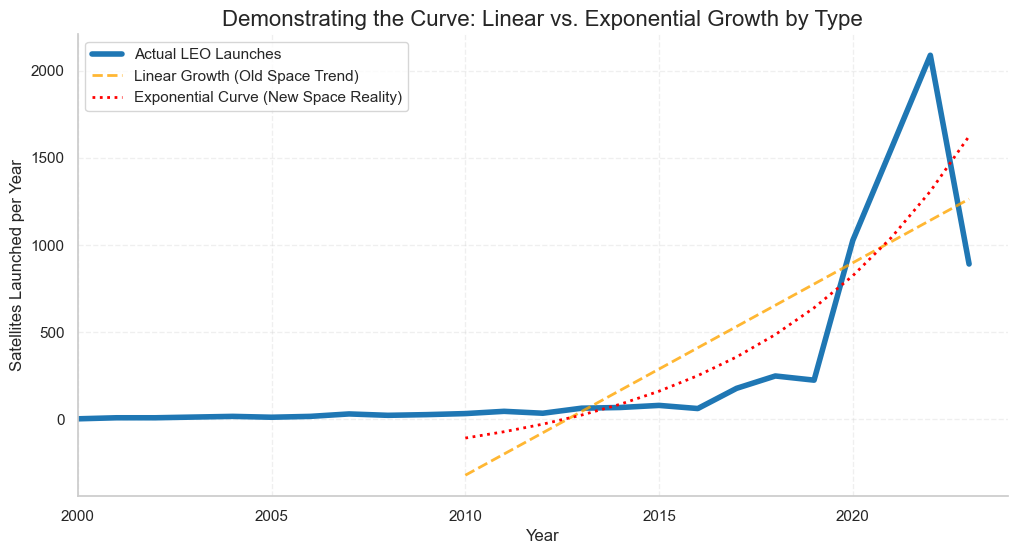

In [14]:
# prepare the data, focus on leo launches
# use the pivot table we already made 
leo_data = orbit_evolution['LEO']
x_years = leo_data.index.values
y_counts = leo_data.values

# Filter for the "New Space" era (2010-Present) to fit the trends
# This avoids the flatline of the 1990s/2000s skewing the math
mask = x_years >= 2010
x_fit = x_years[mask]
y_fit = y_counts[mask]
# Normalize years for math (Year 0, Year 1, etc.)
x_math = x_fit - x_fit.min()

# 2. Define the Math Models
def linear_model(x, m, c):
    return m * x + c  # Straight Line

def exponential_model(x, a, b, c):
    return a * np.exp(b * x) + c  # Hockey Stick Curve

# 3. Calculate the Best Fits
# Linear Fit
lin_params, _ = curve_fit(linear_model, x_math, y_fit)
y_lin_pred = linear_model(x_math, *lin_params)

# Exponential Fit
# p0 helps the math guess the starting curve shape
exp_params, _ = curve_fit(exponential_model, x_math, y_fit, p0=[1, 0.3, 1])
y_exp_pred = exponential_model(x_math, *exp_params)


# 4. Plot the Narrative
plt.figure(figsize=(12, 6))

# The reality of the launches: the real data.
sns.lineplot(x=x_years, y=y_counts, label='Actual LEO Launches', 
             color='#1f77b4', linewidth=4)

# demonstrates plausable growth that follows a linear curve
plt.plot(x_fit, y_lin_pred, label='Linear Growth (Old Space Trend)', 
         color='orange', linestyle='--', linewidth=2, alpha=0.8)

# this shows growth that follows an exponential curve.
plt.plot(x_fit, y_exp_pred, label='Exponential Curve (New Space Reality)', 
         color='red', linestyle=':', linewidth=2)

# clean and simple, clear and easy to read.
plt.title('Demonstrating the Curve: Linear vs. Exponential Growth by Type', fontsize=16)
plt.ylabel('Satellites Launched per Year')
plt.xlabel('Year')
plt.xlim(2000, 2024) # Zoom in on the relevant era
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

sns.despine()
plt.show()

### Conclusion & Next Steps

With the active satellite population (UCS) analyzed, the next phase of this project merges this data with the full historical catalog (SATCAT) to quantify the 'dead' object population and assess the total mass risk in LEO. See satcat_eda.ipynb for the continuation of this analysis.